# Waze Project
**Phase 5 - Build a mchine learning model**

I am close to completing the user churn project. Previously, I used Python to explore and analyze Waze’s user data, create data visualizations, and conduct a hypothesis test. Most recently, I built a binomial logistic regression model based on multiple variables. This model serves as a baseline for more sophisticsted machine learning models we are going to develop in this project.

Now, we want to build a machine learning model to predict user churn. To get the best results, we decides to build and test two tree-based models: random forest and XGBoost.

**The purpose** of this project is to find factors that drive user churn.

**The goal** of this project is to predict whether or not a Waze user is retained or churned.
<br/>
*This project has three steps:*

**Step 1:** Explore and prepare data
* Perform feature selection, extraction, and transformation to prepare the data for modeling

**Step 2:** Model bulding
* Build the models, evaluate them, and advise on next steps

**Step 3:** Results and evaluation


Question to consider while planning this project;

1. What are you being asked to do?
> _Predict if a customer will churn or be retained._

2. What are the ethical implications of the model? What are the consequences of your model making errors?
  * What is the likely effect of the model when it predicts a false negative (i.e., when the model says a Waze user won't churn, but they actually will)?
  > _Waze will fail to take proactive measures to retain users who are likely to stop using the app. For example, Waze might proactively push an app notification to users, or send a survey to better understand user dissatisfaction._
  * What is the likely effect of the model when it predicts a false positive (i.e., when the model says a Waze user will churn, but they actually won't)?
  > _Waze may take proactive measures to retain users who are NOT likely to churn. This may lead to an annoying or negative experience for loyal users of the app._

3. Do the benefits of such a model outweigh the potential problems?
  > _The proactive measueres taken by Waze might have unintended effects on users, and these effects might encourage user churn. Follow-up analysis on the effectiveness of the measures is recommended. If the measures are reasonable and effective, then the benefits will most likely outweigh the problems._

4. Would you proceed with the request to build this model? Why or why not?

  >_Yes. There aren't any significant risks for building such a model._


In [1]:
# Import packages for data manipulation
import numpy as np
import pandas as pd

# Import packages for data visualization
import matplotlib.pyplot as plt

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# Import packages for data modeling
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance
from xgboost import plot_importance

# This module lets us save our models once we fit them.
import pickle

## 1. Explore and Prepare Data

In [2]:
# Import dataset
df0 = pd.read_csv('waze_dataset.csv')

# Copy the df0 dataframe
df = df0.copy()

### Drop Irrelevant Columns

In [3]:
# Drop the ID column
df.drop('ID', axis=1, inplace=True)
df.columns

Index(['label', 'sessions', 'drives', 'total_sessions',
       'n_days_after_onboarding', 'total_navigations_fav1',
       'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives',
       'activity_days', 'driving_days', 'device'],
      dtype='object')

### Handle Outliers

From previous EDA, we know that many of these columns have outliers. However, tree-based models are resilient to outliers, so there is no need to make any imputations.

### Handle Missing Values
Because I know from previous EDA that there is no evidence of a non-random cause of the 700 missing values in the `label` column, and because these observations comprise less than 5% of the data, I use the `dropna()` method to drop the rows that are missing this data.

In [4]:
# Drop rows with missing data in `label` column
df.dropna(subset=['label'], inplace=True)
df['label'].info()

<class 'pandas.core.series.Series'>
Index: 14299 entries, 0 to 14998
Series name: label
Non-Null Count  Dtype 
--------------  ----- 
14299 non-null  object
dtypes: object(1)
memory usage: 223.4+ KB


### Feature engineering

I have already prepared much of data and performed exploratory data analysis (EDA) in previous phases. From that analysis, I know that some features had stronger correlations with churn than others, and I also created some features that may be useful.

In this part of the project, I'll engineer these features and some new features to use for modeling.

#### km_per_driving_day
Create a feature representing the mean number of kilometers driven on each driving day in the last month for each user. Add this feature as a column to `df`.

In [5]:
# 1. Create `km_per_driving_day` feature
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

# 2. Get descriptive stats
df['km_per_driving_day'].describe()

count    1.429900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.675616e+02
50%      3.241789e+02
75%      7.608293e+02
max               inf
Name: km_per_driving_day, dtype: float64

Notice that some values are infinite. This is the result of there being values of zero in the `driving_days` column. Pandas imputes a value of infinity in the corresponding rows of the new column because division by zero is undefined.
<br>Convert these values from infinity to zero. You can use `np.inf` to refer to a value of infinity.

In [6]:
# 1. Convert infinite values to zero
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0

# 2. Confirm that it worked
df['km_per_driving_day'].describe()

count    14299.000000
mean       581.942399
std       1038.254509
min          0.000000
25%        136.168003
50%        273.301012
75%        558.018761
max      15420.234110
Name: km_per_driving_day, dtype: float64

#### percent_sessions_in_last_month
Create a new column `percent_sessions_in_last_month` that represents the percentage of each user's total sessions that were logged in their last month of use.

In [7]:
# 1. Create `percent_sessions_in_last_month` feature
df['percent_sessions_in_last_month'] = df['sessions'] / df['total_sessions']

# 2. Get descriptive stats
df['percent_sessions_in_last_month'].describe()

count    14299.000000
mean         0.449837
std          0.286863
min          0.000000
25%          0.196890
50%          0.424310
75%          0.687251
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

#### professional_driver

Create a new, binary feature called `professional_driver` that is a 1 for users who had 60 or more drives <u>**and**</u> drove on 15+ days in the last month.

**Note:** The objective is to create a new feature that separates professional drivers from other drivers. In this scenario, domain knowledge and intuition are used to determine these deciding thresholds, but ultimately they are arbitrary.

In [8]:
# Create `professional_driver` feature
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

#### total_sessions_per_day

Now, create a new column that represents the mean number of sessions per day _since onboarding_.

In [9]:
# Create `total_sessions_per_day` feature
df['total_sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']

# Get descriptive stats
df['total_sessions_per_day'].describe()

count    14299.000000
mean         0.338207
std          1.319814
min          0.000298
25%          0.050818
50%          0.100457
75%          0.215210
max         39.763874
Name: total_sessions_per_day, dtype: float64

#### km_per_hour

Create a column representing the mean kilometers per hour driven in the last month.

In [12]:
# Create `km_per_hour` feature
df['km_per_hour'] = df['driven_km_drives'] / df['duration_minutes_drives'] / 60
df['km_per_hour'].describe()

count    14299.000000
mean         0.052981
std          0.094424
min          0.020004
25%          0.025180
50%          0.033918
75%          0.053677
max          6.567478
Name: km_per_hour, dtype: float64

#### km_per_drive

Create a column representing the mean number of kilometers per drive made in the last month for each user.

In [13]:
# Create `km_per_drive` feature
df['km_per_drive'] = df['driven_km_drives'] / df['drives']
df['km_per_drive'].describe()

count    1.429900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.325389e+01
50%      7.490594e+01
75%      1.854667e+02
max               inf
Name: km_per_drive, dtype: float64

This feature has infinite values too. Convert the infinite values to zero, then confirm that it worked.



In [14]:
# 1. Convert infinite values to zero
df.loc[df['km_per_drive']==np.inf, 'km_per_drive'] = 0

# 2. Confirm that it worked
df['km_per_drive'].describe()

count    14299.000000
mean       232.269197
std        616.197409
min          0.000000
25%         32.486524
50%         72.947059
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

#### percent_of_sessions_to_favorite

Finally, create a new column that represents the percentage of total sessions that were used to navigate to one of the users' favorite places. Then, print descriptive statistics for the new column.

This is a proxy representation for the percent of overall drives that are to a favorite place. Since total drives since onboarding are not contained in this dataset, total sessions must serve as a reasonable approximation.

People whose drives to non-favorite places make up a higher percentage of their total drives might be less likely to churn, since they're making more drives to less familiar places.

In [15]:
# Create `percent_of_sessions_to_favorite` feature
df['percent_of_drives_to_favorite'] = (
    df['total_navigations_fav1'] + df['total_navigations_fav2']) / df['total_sessions']

# Get descriptive stats
df['percent_of_drives_to_favorite'].describe()

count    14299.000000
mean         1.676347
std          9.021250
min          0.000000
25%          0.206064
50%          0.653572
75%          1.643183
max        777.563629
Name: percent_of_drives_to_favorite, dtype: float64

### Variable Encoding
We have two categorical columns in this dataset; `label` and `device`. To train a machine learning model, we have to change them to numeric values (The technichal jargon for this action is `dumification`).
For the `label` column:
* `retained` -> `0`
* `churned` -> `1`
I save this variable as `blabel` as to not overwrite the original `label` variable.<br>

And for the `device` columns:
* `Android` -> `0`
* `iPhone` -> `1`
I save this variable as `bdevice` as to not overwrite the original `device` variable.<br>


There are many ways to do this. I use `np.where()`.
In cases with many categorical variables, we can use pandas built-in [`pd.get_dummies()`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html), or use scikit-learn's [`OneHotEncoder()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) function.

**Note:** Variables with many categories should only be dummied if absolutely necessary. Each category will result in a coefficient for our model which can lead to overfitting.


In [16]:
# Create binary `label2` column
df['blabel'] = np.where(df['label']=='churned', 1, 0)

# Create new `bdevice` variable
df['bdevice'] = np.where(df['device']=='Android', 0, 1)

df[['device', 'bdevice', 'label', 'blabel']].tail()

,device,bdevice,label,blabel
14994,iPhone,1,retained,0
14995,Android,0,retained,0
14996,iPhone,1,retained,0
14997,iPhone,1,churned,1
14998,iPhone,1,retained,0


### Feature selection

Tree-based models can handle multicollinearity, so we don't need to cut any features.

## 3. Model Building
### Modeling workflow and model selection process

The final modeling dataset contains 14,299 samples. This is towards the lower end of what might be considered sufficient to conduct a robust model selection process, but still doable.

1. Split the data into train/validation/test sets (60/20/20)<br>When deciding the split ratio and whether or not to use a validation set to select a champion model, consider both how many samples will be in each data partition, and how many examples of the minority class each would therefore contain. In this case, a 60/20/20 split would result in \~2,860 samples in each of the validation and test sets, of which \~18%&mdash;or 515 samples&mdash;would represent users who churn.
3. Fit models and tune hyperparameters on the training set
4. Perform final model selection on the validation set
5. Assess the champion model's performance on the test set
<center><img src="Images/model_building.svg" width=800></center>

### Choose evaluation metric

Before modeling, we must decide on an evaluation metric. This will depend on the class balance of the target variable and the use case of the model.

First, examine the class balance of the target variable.


In [20]:
# Get class balance of 'label' col
df['label'].value_counts(normalize=True)

label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64

Approximately 18% of the users in this dataset churned. This is an unbalanced dataset, but not extremely so. It can be modeled without any class rebalancing.

Now, accuracy might not be the best gauge of performance because a model can have high accuracy on an imbalanced dataset and still fail to predict the minority class.

It was already determined that the risks involved in making a false positive prediction are minimal. No one stands to get hurt, lose money, or suffer any other significant consequence if they are predicted to churn. Therefore, I select the model based on the recall score.

### Split the data

In [22]:
# 1. Isolate X variables
X = df.drop(columns=['label', 'blabel', 'device'])

# 2. Isolate y variable
y = df['blabel']

# 3. Split into train and test sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, stratify=y,
                                              test_size=0.2, random_state=42)

# 4. Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr,
                                                  test_size=0.25, random_state=42)

In [23]:
# Verify the number of samples in the partitioned data.
for x in [X_train, X_val, X_test]:
    print(len(x))

8579
2860
2860


### Build Random forest Model

Begin with using `GridSearchCV` to tune a random forest model.

1. Instantiate the random forest classifier `rf` and set the random state.

2. Create a dictionary `cv_params` of any of the following hyperparameters and their corresponding values to tune. The more you tune, the better your model will fit the data, but the longer it will take.
 - `max_depth`: Maximum depth of each tree. Deeper trees can capture more complex patterns, but also risk overfitting.
 - `max_features`: Number of features considered for splitting at each node. A common value is ‘sqrt’ (square root of the total number of features).
 - `max_samples`: If bootstrap is True, the number of samples to draw from X to train each base estimator.
 - `min_samples_leaf`: The minimum number of samples required to be at a leaf node.
 - `min_samples_split`: The minimum number of samples required to split an internal node
 - `n_estimators`: Number of trees in the forest. More trees generally lead to better performance, but at the cost of computational time.

3. Define a dictionary `scoring` of scoring metrics for GridSearch to capture (precision, recall, F1 score, and accuracy).

4. Instantiate the `GridSearchCV` object `rf_cv`. Pass to it as arguments:
 - estimator=`rf`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit=_`)

 `refit` should be set to `'recall'`.<font/>


**Note:** In this step, we doesn't use multiple values for each parameter in the grid search, but we should include a range of values in your search to home in on the best set of parameters in future.

In [26]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [1.0],
             'min_samples_leaf': [2],
             'min_samples_split': [2],
             'n_estimators': [300],
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall')

In [27]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: total: 2min 50s
Wall time: 2min 54s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [1.0], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [28]:
# Examine best score
rf_cv.best_score_

np.float64(0.12678201409034398)

In [29]:
# Examine best hyperparameter combo
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [30]:
# `make_results()` function outputs all of the scores of model.
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

In [31]:
# Pass the `GridSearch` object to the `make_results()` function.
results = make_results('RF cv', rf_cv, 'recall')
results

,model,precision,recall,F1,accuracy
0,RF cv,0.458198,0.126782,0.198534,0.818626


Asside from the accuracy, the scores aren't that good. However, recall that when we built the logistic regression model in the last project, the recall was \~0.09, which means that this model has 33% better recall and about the same accuracy, and it was trained on less data.

### Build XGBoost Model

 Try to improve scores using an XGBoost model.

1. Instantiate the XGBoost classifier `xgb` and set `objective='binary:logistic'`. Also set the random state.

2. Create a dictionary `cv_params` of the following hyperparameters and their corresponding values to tune:
 - `max_depth`
 - `min_child_weight`
 - `learning_rate`
 - `n_estimators`

3. Define a dictionary `scoring` of scoring metrics for grid search to capture (precision, recall, F1 score, and accuracy).

4. Instantiate the `GridSearchCV` object `xgb_cv`. Pass to it as arguments:
 - estimator=`xgb`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit='recall'`)

In [35]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

In [36]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: total: 3min 17s
Wall time: 1min 2s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5], 'n_estimators': [300]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [37]:
# Examine best score
xgb_cv.best_score_

np.float64(0.1708264263019754)

In [38]:
# Examine best parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 300}

In [39]:
# Call 'make_results()' on the GridSearch object
xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.458198,0.126782,0.198534,0.818626
0,XGB cv,0.425932,0.170826,0.243736,0.811866


This model fit the data even better than the random forest model. The recall score is nearly double the recall score from the logistic regression model from the previous phase, and it's almost 50% better than the random forest model's recall score, while maintaining a similar accuracy and precision score.

## 4. Model selection

Now, use the best random forest model and the best XGBoost model to predict on the validation data. Whichever performs better will be selected as the champion model.

### Random forest

In [40]:
# Use random forest model to predict on validation data
rf_val_preds = rf_cv.best_estimator_.predict(X_val)

In [41]:
# The get_test_scores() function generates a table of scores from the predictions on the validation data
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [42]:
# Get validation scores for RF model
rf_val_scores = get_test_scores('RF val', rf_val_preds, y_val)

# Append to the results table
results = pd.concat([results, rf_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.458198,0.126782,0.198534,0.818626
0,XGB cv,0.425932,0.170826,0.243736,0.811866
0,RF val,0.445255,0.120316,0.189441,0.817483


The scores went down from the training scores across all metrics, but only by very little. This means that the model did not overfit the training data.

### XGBoost

Now, The same thing to get the performance scores of the XGBoost model on the validation data.

In [43]:
# Use XGBoost model to predict on validation data
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

# Get validation scores for XGBoost model
xgb_val_scores = get_test_scores('XGB val', xgb_val_preds, y_val)

# Append to the results table
results = pd.concat([results, xgb_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.458198,0.126782,0.198534,0.818626
0,XGB cv,0.425932,0.170826,0.243736,0.811866
0,RF val,0.445255,0.120316,0.189441,0.817483
0,XGB val,0.422680,0.161736,0.233951,0.812238


Just like with the random forest model, the XGBoost model's validation scores were lower, but only very slightly. It is still the clear champion.

## 5. Prediction Using the Champion Model on Test Data

Now, I use the champion model to predict on the test dataset. This is to give a final indication of how one should expect the model to perform on new future data, should we decide to use the model.

In [44]:
# Use XGBoost model to predict on test data
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# Get test scores for XGBoost model
xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

# Append to the results table
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.458198,0.126782,0.198534,0.818626
0,XGB cv,0.425932,0.170826,0.243736,0.811866
0,RF val,0.445255,0.120316,0.189441,0.817483
0,XGB val,0.422680,0.161736,0.233951,0.812238
0,XGB test,0.423963,0.181460,0.254144,0.811189


The recall was 50% better more than it was on the validation data, but the precision declined notably. Nonetheless, this is stil within the acceptable range for performance discrepancy between validation and test scores.

## 6. Evaluation of Champion Model
### Confusion matrix

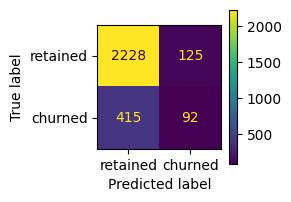

In [46]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['retained', 'churned'])
fig, ax = plt.subplots(figsize=(2,2))
disp.plot(ax=ax);


The model predicted three times as many false negatives than it did false positives, and it correctly identified only 16.6% of the users who actually churned.

### Feature importance

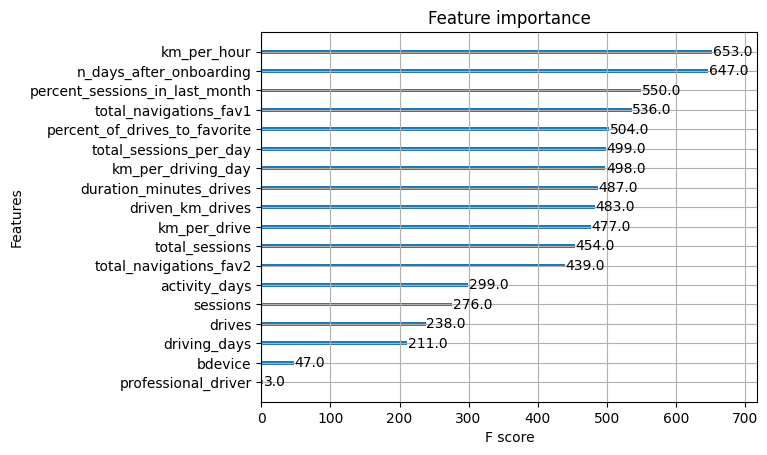

In [47]:
plot_importance(xgb_cv.best_estimator_);

The XGBoost model made more use of many of the features than did the logistic regression model from the previous phase, which weighted a single feature (`activity_days`) very heavily in its final prediction.

If anything, this underscores the importance of feature engineering. Notice that engineered features accounted for six of the top 10 features (and three of the top five). Feature engineering is often one of the best and easiest ways to boost model performance.

Also, note that the important features in one model might not be the same as the important features in another model. That's why we shouldn't discount features as unimportant without thoroughly examining them and understanding their relationship with the dependent variable, if possible. These discrepancies between features selected by models are typically caused by complex feature interactions.

Remember, sometimes our data simply will not be predictive of our chosen target. This is common. Machine learning is a powerful tool, but it is not magic. If our data does not contain predictive signal, even the most complex algorithm will not be able to deliver consistent and accurate predictions. Do not be afraid to draw this conclusion.

Even if we cannot use the model to make strong predictions, was the work done in vain? What insights can we report back to stakeholders?

## 7. Conclusion

Now that we've built and tested our machine learning models, the next step is to share our findings with the Waze leadership team. Here are the questions to consider as we prepare to write the executive summary.

**Questions:**

1. Would you recommend using this model for churn prediction? Why or why not?

> _It depends. What would the model be used for? If it's used to drive consequential business decisions, then no. The model is not a strong enough predictor, as made clear by its poor recall score. However, if the model is only being used to guide further exploratory efforts, then it can have value._

2. What tradeoff was made by splitting the data into training, validation, and test sets as opposed to just training and test sets?

> _Splitting the data three ways means that there is less data available to train the model than splitting just two ways. However, performing model selection on a separate validation set enables testing of the champion model by itself on the test set, which gives a better estimate of future performance than splitting the data two ways and selecting a champion model by performance on the test data._

3. What is the benefit of using a logistic regression model over an ensemble of tree-based models (like random forest or XGBoost) for classification tasks?

> _Logistic regression models are easier to interpret. Because they assign coefficients to predictor variables, they reveal not only which features factored most heavily into their final predictions, but also the directionality of the weight. In other words, they tell you if each feature is positively or negatively correlated with the target in the model's final prediction._

4. What is the benefit of using an ensemble of tree-based models like random forest or XGBoost over a logistic regression model for classification tasks?

> _Tree-based model ensembles are often better predictors. If the most important thing is the predictive power of the model, then tree-based modeling will usually win out against logistic regression (but not always!). They also require much less data cleaning and require fewer assumptions about the underlying distributions of their predictor variables, so they're easier to work with._

5. What could you do to improve this model?

> _New features could be engineered to try to generate better predictive signal, as they often do if you have domain knowledge. In the case of this model, the engineered features made up over half of the top 10 most-predictive features used by the model. It could also be helpful to reconstruct the model with different combinations of predictor variables to reduce noise from unpredictive features._

6. What additional features would you like to have to help improve the model?

> _It would be helpful to have drive-level information for each user (such as drive times, geographic locations, etc.). It would probably also be helpful to have more granular data to know how users interact with the app. For example, how often do they report or confirm road hazard alerts? Finally, it could be helpful to know the monthly count of unique starting and ending locations each driver inputs._


## 8. BONUS
### Identify an optimal decision threshold

The default decision threshold for most implementations of classification algorithms&mdash;including scikit-learn's&mdash;is 0.5. This means that, in the case of the Waze models, if they predicted that a given user had a 50% probability or greater of churning, then that user was assigned a predicted value of `1`&mdash;the user was predicted to churn.

With imbalanced datasets where the response class is a minority, this threshold might not be ideal. We learned that a precision-recall curve can help to visualize the trade-off between our model's precision and recall.

Here's the precision-recall curve for the XGBoost champion model on the test data.

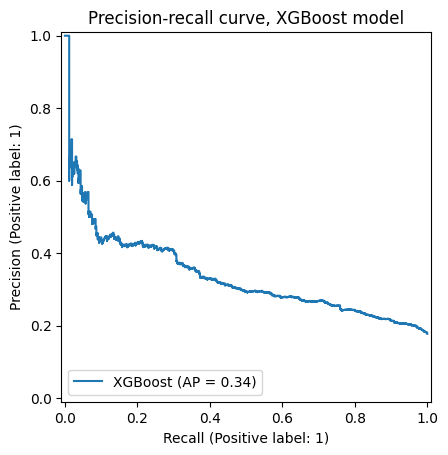

In [48]:
# Plot precision-recall curve
display = PrecisionRecallDisplay.from_estimator(
    xgb_cv.best_estimator_, X_test, y_test, name='XGBoost'
    )
plt.title('Precision-recall curve, XGBoost model');

As recall increases, precision decreases. But what if we determined that false positives aren't much of a problem? For example, in the case of this Waze project, a false positive could just mean that a user who will not actually churn gets an email and a banner notification on their phone. It's very low risk.

So, what if instead of using the default 0.5 decision threshold of the model, we used a lower threshold?

Here's an example where the threshold is set to 0.4:

In [49]:
# Get predicted probabilities on the test data
predicted_probabilities = xgb_cv.best_estimator_.predict_proba(X_test)
predicted_probabilities

array([[0.94572806, 0.05427194],
       [0.57626796, 0.42373204],
       [0.98132175, 0.01867824],
       ...,
       [0.8135836 , 0.18641636],
       [0.9661311 , 0.03386891],
       [0.7386279 , 0.26137212]], dtype=float32)

The `predict_proba()` method returns a 2-D array of probabilities where each row represents a user. The first number in the row is the probability of belonging to the negative class, the second number in the row is the probability of belonging to the positive class. (Notice that the two numbers in each row are complimentary to each other and sum to one.)

We can generate new predictions based on this array of probabilities by changing the decision threshold for what is considered a positive response. For example, the following code converts the predicted probabilities to {0, 1} predictions with a threshold of 0.4. In other words, any users who have a value ≥ 0.4 in the second column will get assigned a prediction of `1`, indicating that they churned.

In [50]:
# Create a list of just the second column values (probability of target)
probs = [x[1] for x in predicted_probabilities]

# Create an array of new predictions that assigns a 1 to any value >= 0.4
new_preds = np.array([1 if x >= 0.4 else 0 for x in probs])
new_preds

array([0, 1, 0, ..., 0, 0, 0])

In [51]:
# Get evaluation metrics for when the threshold is 0.4
get_test_scores('XGB, threshold = 0.4', new_preds, y_test)

,model,precision,recall,F1,accuracy
0,"XGB, threshold = 0.4",0.414986,0.284024,0.337237,0.802098


In [52]:
# Compare these numbers with the results from earlier.
results

,model,precision,recall,F1,accuracy
0,RF cv,0.458198,0.126782,0.198534,0.818626
0,XGB cv,0.425932,0.170826,0.243736,0.811866
0,RF val,0.445255,0.120316,0.189441,0.817483
0,XGB val,0.422680,0.161736,0.233951,0.812238
0,XGB test,0.423963,0.181460,0.254144,0.811189


Recall and F1 score increased significantly, while precision and accuracy decreased.

So, using the precision-recall curve as a guide, suppose we knew that we'd be satisfied if the model had a recall score of 0.5 and we were willing to accept the \~30% precision score that comes with it. In other words, we'd be happy if the model successfully identified half of the people who will actually churn, even if it means that when the model says someone will churn, it's only correct about 30% of the time.

What threshold will yield this result? There are a number of ways to determine this. Here's one way that uses a function to accomplish this.

In [53]:
def threshold_finder(y_test_data, probabilities, desired_recall):
    '''
    Find the decision threshold that most closely yields a desired recall score.

    Inputs:
        y_test_data: Array of true y values
        probabilities: The results of the `predict_proba()` model method
        desired_recall: The recall that you want the model to have

    Outputs:
        threshold: The decision threshold that most closely yields the desired recall
        recall: The exact recall score associated with `threshold`
    '''
    probs = [x[1] for x in probabilities]  # Isolate second column of `probabilities`
    thresholds = np.arange(0, 1, 0.001)    # Set a grid of 1,000 thresholds to test

    scores = []
    for threshold in thresholds:
        # Create a new array of {0, 1} predictions based on new threshold
        preds = np.array([1 if x >= threshold else 0 for x in probs])
        # Calculate recall score for that threshold
        recall = recall_score(y_test_data, preds)
        # Append the threshold and its corresponding recall score as a tuple to `scores`
        scores.append((threshold, recall))

    distances = []
    for idx, score in enumerate(scores):
        # Calculate how close each actual score is to the desired score
        distance = abs(score[1] - desired_recall)
        # Append the (index#, distance) tuple to `distances`
        distances.append((idx, distance))

    # Sort `distances` by the second value in each of its tuples (least to greatest)
    sorted_distances = sorted(distances, key=lambda x: x[1], reverse=False)
    # Identify the tuple with the actual recall closest to desired recall
    best = sorted_distances[0]
    # Isolate the index of the threshold with the closest recall score
    best_idx = best[0]
    # Retrieve the threshold and actual recall score closest to desired recall
    threshold, recall = scores[best_idx]

    return threshold, recall


Now, test the function to find the threshold that results in a recall score closest to 0.5.

In [54]:
# Get the predicted probabilities from the champion model
probabilities = xgb_cv.best_estimator_.predict_proba(X_test)

# Call the function
threshold_finder(y_test, probabilities, 0.5)

(np.float64(0.194), np.float64(0.4990138067061144))

Setting a threshold of 0.124 will result in a recall of 0.503.

To verify, you can repeat the steps performed earlier to get the other evaluation metrics for when the model has a threshold of 0.124. Based on the precision-recall curve, a 0.5 recall score should have a precision of \~0.3.

In [55]:
# Create an array of new predictions that assigns a 1 to any value >= 0.124
new_preds = np.array([1 if x >= 0.124 else 0 for x in probs])

# Get evaluation metrics for when the threshold is 0.124
get_test_scores('XGB, threshold = 0.124', new_preds, y_test)

,model,precision,recall,F1,accuracy
0,"XGB, threshold = 0.124",0.269262,0.654832,0.381609,0.623776


It worked! Now we understand that changing the decision threshold is another tool that can help us achieve useful results from our model.